In [1]:
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import unicodedata

import re
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
import sys
sys.path.insert(0, '../src')
from metrics import metrics

In [4]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 70

In [5]:
hidden_size = 64

In [6]:
df = pd.read_csv('../data/internal/preprocessed.csv', index_col=0)

In [7]:
reference_texts     = df['reference'].tolist()
translation_texts   = df['translation'].tolist()

In [8]:
train_ratio = 0.8
val_test_ratio = 0.5

ref_train, ref_val, trn_train, trn_val = train_test_split(reference_texts, translation_texts, test_size=(1-train_ratio), random_state=42)
ref_val, ref_test, trn_val, trn_test = train_test_split(ref_val, trn_val, test_size=val_test_ratio, random_state=42)

In [9]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def __len__(self):
        return self.n_words

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    
def normalize_text(text):
    s = unicodeToAscii(text.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [11]:
def readLangs(lang1, lang2, input_texts, output_texts, reverse=False):
    print("Reading lines...")

    # Split every line into pairs and normalize
    pairs = list(zip(input_texts, output_texts))

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [12]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [13]:
def prepareData(lang1, lang2, input_texts, output_texts, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, input_texts, output_texts, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('non-toxic', 'toxic', ref_train, trn_train, True)
print(random.choice(pairs))

Reading lines...
Read 80584 sentence pairs
Trimmed to 80584 sentence pairs
Counting words...
Counted words:
toxic 51472
non-toxic 48569
["Maybe your friend's trying to rip us off, I found the photo you took in the tomb.", 'your boyfriend may have tried to fuck us, I found the picture you made in the tomb.']


In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(ref, trn, batch_size):
    input_lang, output_lang, pairs = prepareData('non-toxic', 'toxic', ref, trn, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
batch_size = 38

input_lang, output_lang, train_dataloader = get_dataloader(ref_train, trn_train, batch_size)
_, _, validation_dataloader = get_dataloader(ref_val, trn_val, batch_size)
_, _, test_dataloader = get_dataloader(ref_test, trn_test, batch_size)

Reading lines...
Read 80584 sentence pairs
Trimmed to 80584 sentence pairs
Counting words...
Counted words:
toxic 51472
non-toxic 48569
Reading lines...
Read 10073 sentence pairs
Trimmed to 10073 sentence pairs
Counting words...
Counted words:
toxic 13482
non-toxic 13182
Reading lines...
Read 10074 sentence pairs
Trimmed to 10074 sentence pairs
Counting words...
Counted words:
toxic 13370
non-toxic 13046


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [18]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = nn.functional.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [19]:
import matplotlib.pyplot as plt

def showPlot(train_losses, test_losses, epoch):
    plt.figure()
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(loc="upper right")
    plt.title(f'Losses on epoch {epoch}')
    plt.show()
    
def showScores(val_scores, epoch):
    plt.figure()
    plt.plot(val_scores, label='Validation score')
    plt.legend(loc="upper right")
    plt.title(f'BLUE scores on epoch {epoch}')
    plt.show()

In [20]:
def train_epoch(epoch, dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    encoder.train().to(device)
    decoder.train().to(device)

    total_loss = 0
    bar = tqdm(dataloader)
    
    bar.set_description(f'Train epoch {epoch}')
    
    for input_tensor, target_tensor in bar:
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()
        bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

In [21]:
def val_epoch(epoch, dataloader, encoder, decoder, criterion):

      total_loss = 0
      
      encoder.eval()
      decoder.eval()
    
      with torch.no_grad():
            bar = tqdm(dataloader)
            
            bar.set_description(f'Evaluation epoch {epoch}')
            
            decoded_targets = []
            decoded_predictions = []
            
            for input_tensor, target_tensor in bar:
                  input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

                  encoder_outputs, encoder_hidden = encoder(input_tensor)
                  decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

                  loss = criterion(
                  decoder_outputs.view(-1, decoder_outputs.size(-1)),
                  target_tensor.view(-1)
                  )
                  
                  total_loss += loss.item()

                  _, topi = decoder_outputs.topk(1, dim=2)
                  decoded_ids = topi.squeeze()
                  
                  for ids in decoded_ids:
                        sentence = []
                        for idx in ids:
                              if idx.item() == EOS_token:
                                    break
                              sentence.append(output_lang.index2word[idx.item()])
                        decoded_predictions.append(" ".join(sentence))
                  
                  for ids in target_tensor:
                        sentence = []
                        for idx in ids:
                              if idx.item() == EOS_token:
                                    break
                              sentence.append(output_lang.index2word[idx.item()])
                        decoded_targets.append(" ".join(sentence))
                  
                  bar.set_postfix({'loss': loss.item()})
      
            blue = metrics.blue(decoded_predictions, decoded_targets)

      return total_loss / len(dataloader), blue

In [22]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=1, evaluate_every=1, plot_every=1, load_ckpt=False, load_ckpt_path=None, save_ckpt_path="best.pt"):
    
    if load_ckpt_path is None:
        load_ckpt_path = save_ckpt_path
    
    # best score for checkpointing
    best = 0.0
    train_losses = []
    val_losses = []
    val_scores = []
    
    first_epoch = 1
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    isCkptExists = os.path.isfile(load_ckpt_path)
    
    if (load_ckpt and not isCkptExists):
        print('Checkpoint file does not exist. Training model from scratch!')
    
    if (load_ckpt and isCkptExists):
        checkpoint = torch.load(load_ckpt_path)
        best = checkpoint['best_score']
        encoder.load_state_dict(checkpoint['encoder_state_dict'])
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        train_losses = checkpoint['train_losses']
        val_scores = checkpoint['val_scores']
        val_losses = checkpoint['val_losses']
        first_epoch = checkpoint['epoch'] + 1
    
    print_train_loss_total = 0  # Reset every print_every
    print_val_loss_total = 0  # Reset every evaluate_every

    criterion = nn.NLLLoss()

    for epoch in range(first_epoch, n_epochs + first_epoch):            
            
        train_loss = train_epoch(epoch, train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        train_losses.append(train_loss)
        
        if epoch % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print(f'Train: (epoch {epoch}%) Loss: {print_train_loss_avg:.4f}')
        
        if epoch % evaluate_every == 0:    
            val_loss, val_score = val_epoch(epoch, val_dataloader, encoder, decoder, criterion)
            
            print_val_loss_total += val_loss
            val_losses.append(val_loss)
            val_scores.append(val_score)
            print_val_loss_avg = print_val_loss_total / print_every
            print_val_loss_total = 0
            
            if val_score > best:
                best = val_score
                torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_scores': val_scores,
                'best_score': best,
                }, save_ckpt_path)
                  
            print(f'Evaluation: (epoch {epoch}) Loss: {print_val_loss_avg:.4f}, Score: {val_score:.4f}')

            
        if epoch % plot_every == 0:
            showPlot(train_losses, val_losses, epoch)
            showScores(val_scores, epoch)

In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

Checkpoint file does not exist. Training model from scratch!


Train epoch 1: 100%|██████████| 2121/2121 [07:44<00:00,  4.57it/s, loss=0.689]


Train: (epoch 1%) Loss: 0.9732


Evaluation epoch 1: 100%|██████████| 266/266 [00:37<00:00,  7.12it/s, loss=0.886]


Evaluation: (epoch 1) Loss: 1.1950, Score: 0.0042


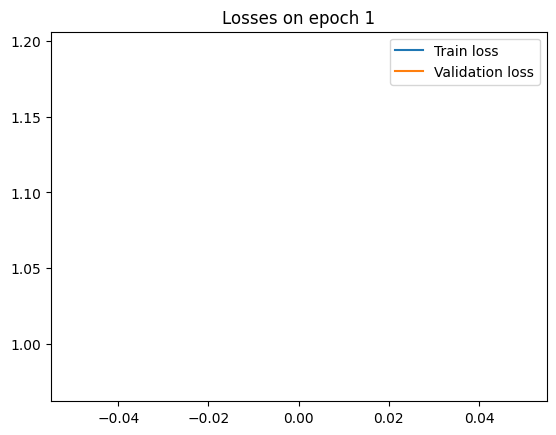

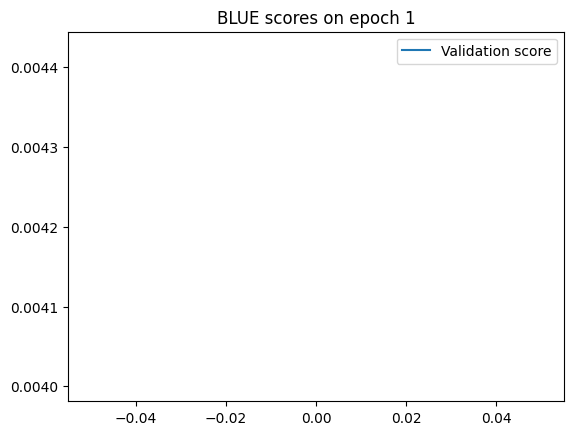

Train epoch 2: 100%|██████████| 2121/2121 [07:53<00:00,  4.48it/s, loss=0.708]


Train: (epoch 2%) Loss: 0.7127


Evaluation epoch 2: 100%|██████████| 266/266 [00:37<00:00,  7.04it/s, loss=0.951]


Evaluation: (epoch 2) Loss: 1.2414, Score: 0.0070


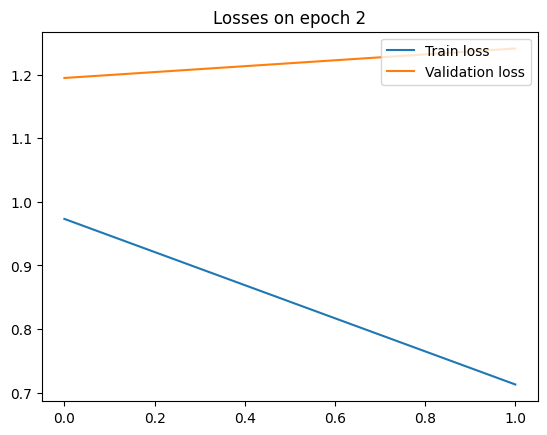

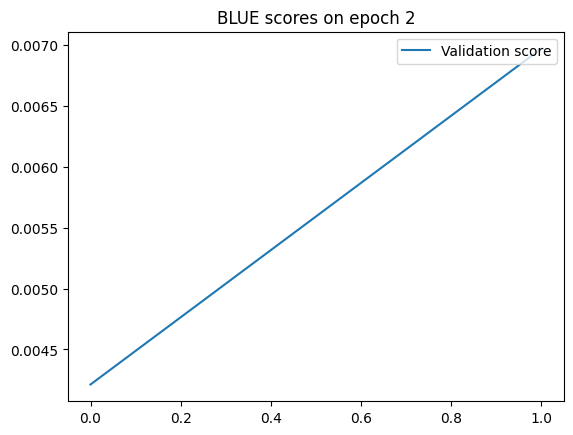

Train epoch 3: 100%|██████████| 2121/2121 [07:40<00:00,  4.60it/s, loss=0.751]


Train: (epoch 3%) Loss: 0.6394


Evaluation epoch 3: 100%|██████████| 266/266 [00:37<00:00,  7.09it/s, loss=1.78] 


Evaluation: (epoch 3) Loss: 1.2829, Score: 0.0091


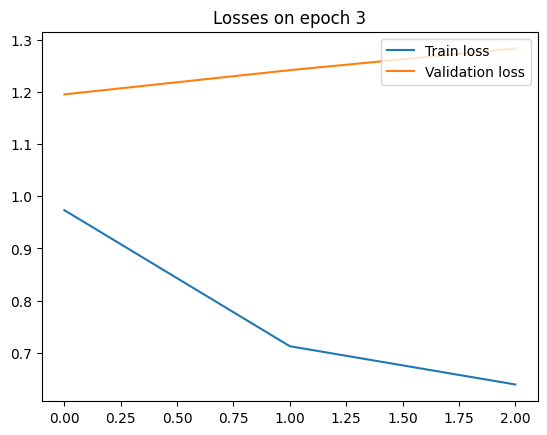

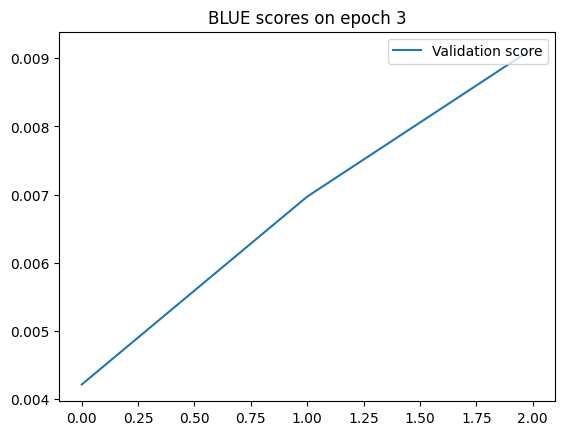

Train epoch 4: 100%|██████████| 2121/2121 [07:38<00:00,  4.62it/s, loss=0.472]


Train: (epoch 4%) Loss: 0.5873


Evaluation epoch 4: 100%|██████████| 266/266 [00:38<00:00,  6.94it/s, loss=0.753]


Evaluation: (epoch 4) Loss: 1.3129, Score: 0.0088


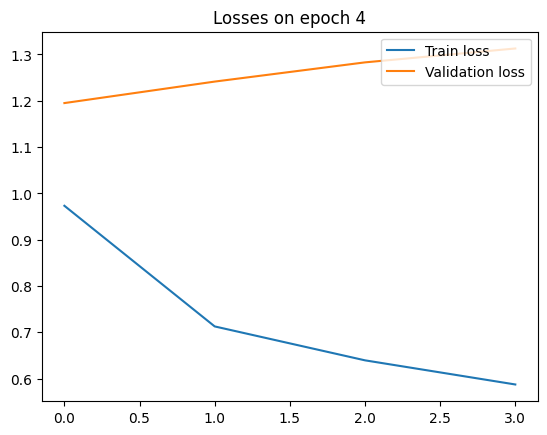

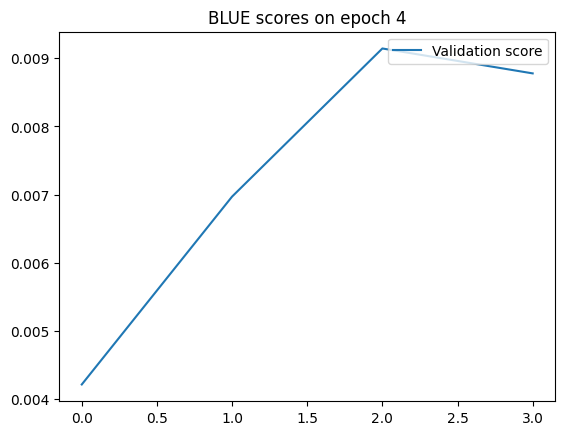

Train epoch 5: 100%|██████████| 2121/2121 [07:43<00:00,  4.58it/s, loss=0.537]


Train: (epoch 5%) Loss: 0.5502


Evaluation epoch 5: 100%|██████████| 266/266 [00:39<00:00,  6.69it/s, loss=0.897]


Evaluation: (epoch 5) Loss: 1.3410, Score: 0.0307


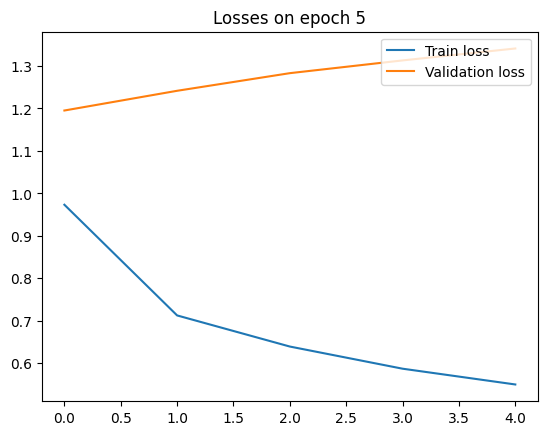

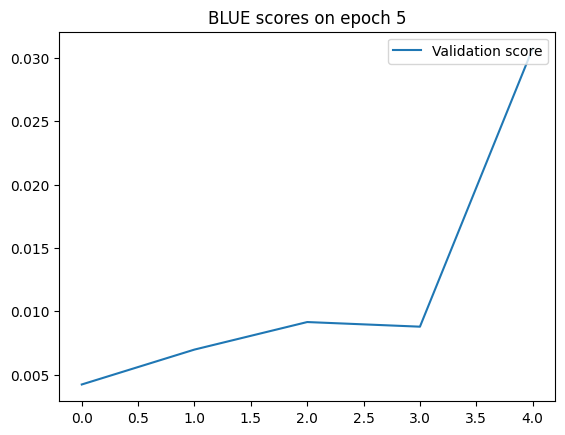

Train epoch 6: 100%|██████████| 2121/2121 [07:39<00:00,  4.61it/s, loss=0.539]


Train: (epoch 6%) Loss: 0.5209


Evaluation epoch 6: 100%|██████████| 266/266 [00:38<00:00,  6.84it/s, loss=1.23]


Evaluation: (epoch 6) Loss: 1.3684, Score: 0.0566


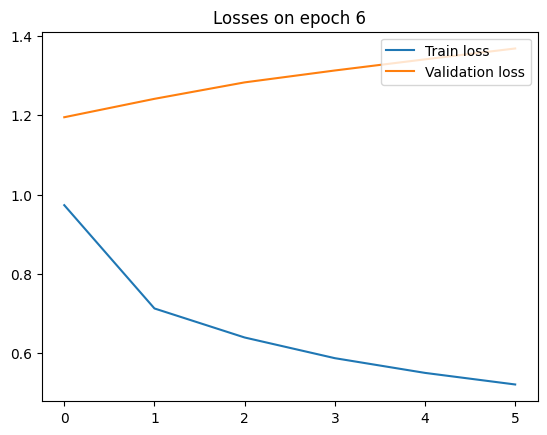

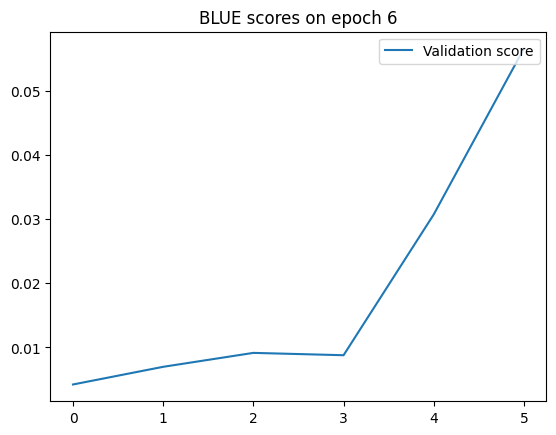

Train epoch 7: 100%|██████████| 2121/2121 [07:34<00:00,  4.67it/s, loss=0.502]


Train: (epoch 7%) Loss: 0.4963


Evaluation epoch 7: 100%|██████████| 266/266 [00:38<00:00,  6.85it/s, loss=1.69]


Evaluation: (epoch 7) Loss: 1.3956, Score: 0.0567


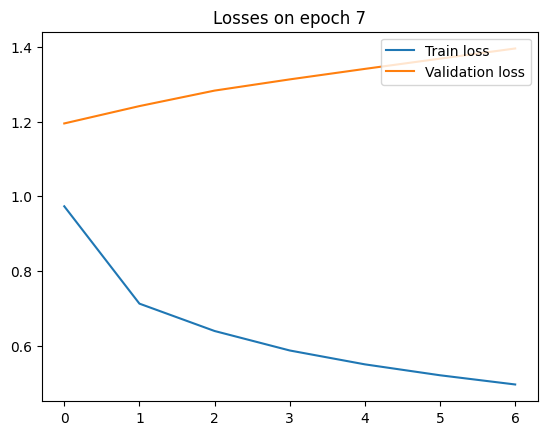

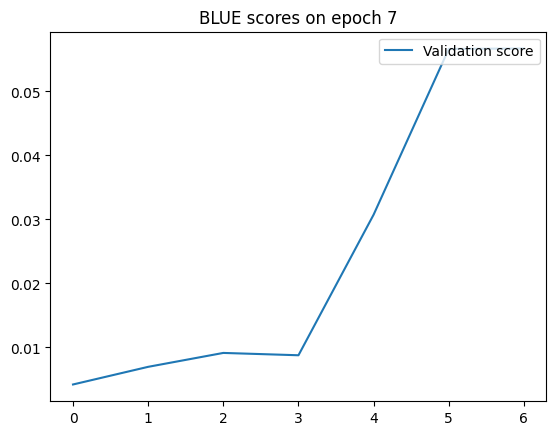

Train epoch 8: 100%|██████████| 2121/2121 [07:38<00:00,  4.63it/s, loss=0.59] 


Train: (epoch 8%) Loss: 0.4749


Evaluation epoch 8: 100%|██████████| 266/266 [00:39<00:00,  6.79it/s, loss=1.43]


Evaluation: (epoch 8) Loss: 1.4168, Score: 0.0339


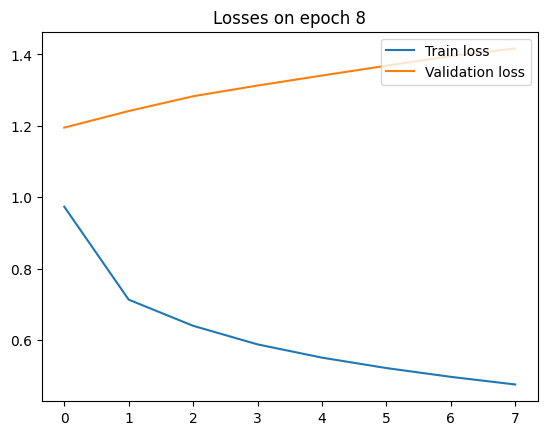

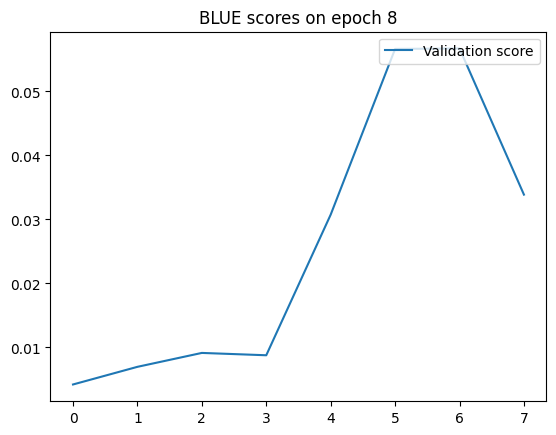

Train epoch 9: 100%|██████████| 2121/2121 [07:38<00:00,  4.62it/s, loss=0.571]


Train: (epoch 9%) Loss: 0.4562


Evaluation epoch 9: 100%|██████████| 266/266 [00:39<00:00,  6.73it/s, loss=1.3] 


Evaluation: (epoch 9) Loss: 1.4398, Score: 0.0575


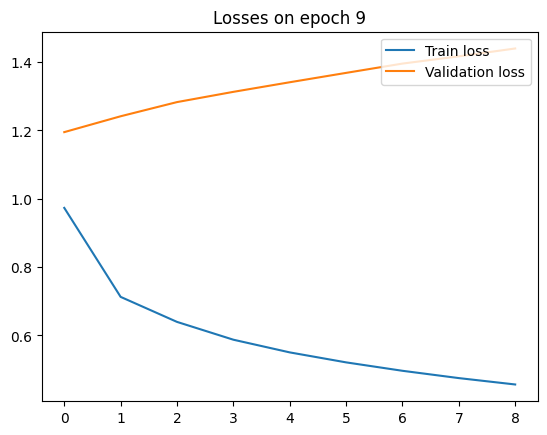

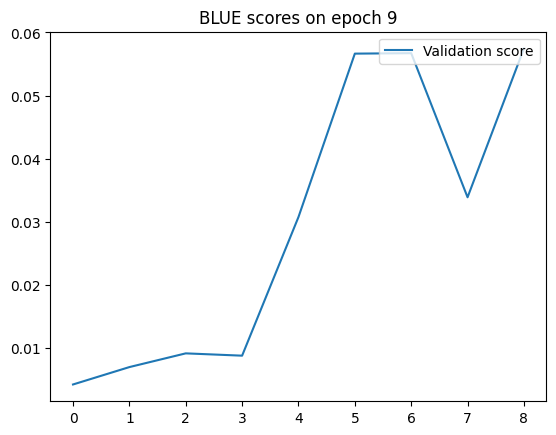

Train epoch 10: 100%|██████████| 2121/2121 [07:36<00:00,  4.65it/s, loss=0.455]


Train: (epoch 10%) Loss: 0.4392


Evaluation epoch 10: 100%|██████████| 266/266 [00:39<00:00,  6.81it/s, loss=1.86]


Evaluation: (epoch 10) Loss: 1.4619, Score: 0.0555


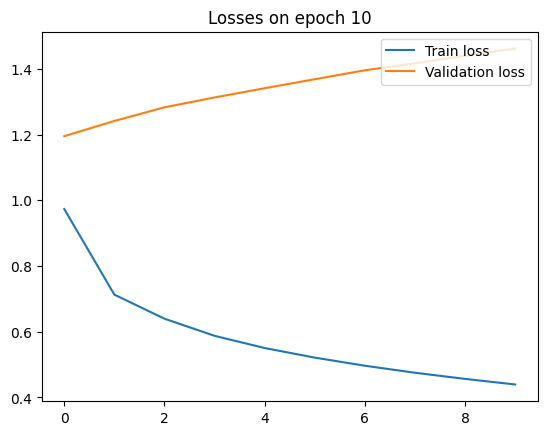

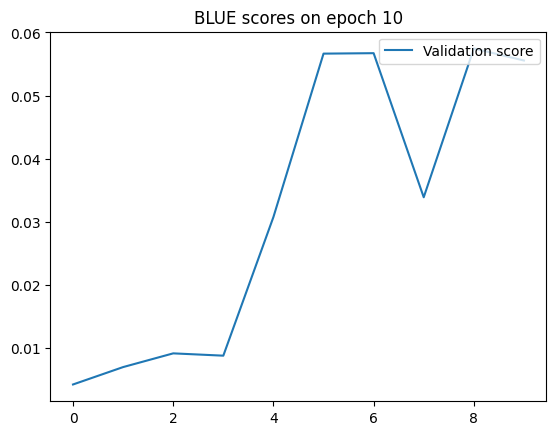

In [57]:
encoder = EncoderRNN(len(input_lang), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(output_lang)).to(device)

train(train_dataloader, validation_dataloader, encoder, decoder, 10, load_ckpt=True, save_ckpt_path="../models/transformer_vocab/best.pt")

In [24]:
encoder = EncoderRNN(len(input_lang), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(output_lang)).to(device)

checkpoint = torch.load('../models/transformer_vocab/best.pt')

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [25]:
def test_model(dataloader, encoder, decoder):      
      encoder.eval()
      decoder.eval()
    
      with torch.no_grad():
            bar = tqdm(dataloader, desc='Evaluation')
            
            decoded_targets = []
            decoded_predictions = []
            
            for input_tensor, target_tensor in bar:
                  input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

                  encoder_outputs, encoder_hidden = encoder(input_tensor)
                  decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
                  
                  _, topi = decoder_outputs.topk(1, dim=2)
                  decoded_ids = topi.squeeze()
                
                  for ids in decoded_ids:
                        sentence = []
                        for idx in ids:
                              if idx.item() == EOS_token:
                                    break
                              sentence.append(output_lang.index2word[idx.item()])
                        decoded_predictions.append(" ".join(sentence))
                  
                  for ids in target_tensor:
                        sentence = []
                        for idx in ids:
                              if idx.item() == EOS_token:
                                    break
                              sentence.append(output_lang.index2word[idx.item()])
                        decoded_targets.append(" ".join(sentence))
                  
            blue_score = metrics.blue(decoded_predictions, decoded_targets)
            similarity_score = metrics.content_similarity({'device':device, 'batch_size':512}, decoded_predictions, decoded_targets)
            fluency_score = metrics.fluency({'device':device, 'batch_size':256}, decoded_predictions)
            sta_score = metrics.style_transfer_accuracy({'device':device, 'batch_size':256}, decoded_predictions)
 
      return blue_score, similarity_score, fluency_score, sta_score

In [26]:
blue_score, similarity_score, fluency_score, sta_score = test_model(test_dataloader, encoder, decoder)

100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
print('BLUE:', blue_score)
print('Similarity:', similarity_score)
print('Fluency:', fluency_score)
print('STA:', sta_score)

BLUE: 0.035913383952844706
Similarity: 0.11880102008581161
Fluency: 0.2107839733362198
STA: 9.926543134497479e-05
